# SQL Business Analysis Project
-----

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

## Function to takes a SQL query as an argument and returns a pandas dataframe of that query
-------

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

## Function that takes a SQL command as an argument and executes it using the sqlite module
-------

In [3]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)


## Function that calls the run_query() function to return a list of all tables and views in the database
----

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Album to Purchase
-----
### Recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres
Query that returns each genre, with the number of tracks sold in the USA:
in absolute numbers
in percentages.

In [5]:
albums_to_purchase = '''
WITH usa_tracks_sold AS (
    
    SELECT  il.* FROM customer c 
INNER JOIN invoice i on c.customer_id = i.customer_id
INNER JOIN invoice_line il on i.invoice_id = il.invoice_id
WHERE c.country = "USA" )

select g.name genre, count(uts.invoice_line_id) tracks_sold, cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold 
    FROM usa_tracks_sold uts
    INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
group by 1
order by 2 desc
limit 5
    '''
run_query(albums_to_purchase)


,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253


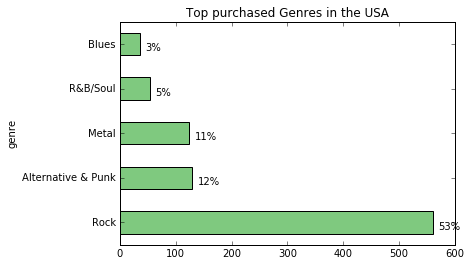

In [6]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)
genre_sales_usa['tracks_sold'].plot.barh(title="Top purchased Genres in the USA",
    xlim=(0, 600),
    colormap=plt.cm.Accent)

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

The three artists whose albums we should purchase based on sales of tracks from their genres are:
* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

# Employee performance
------
###  Query that finds the total dollar amount of sales assigned to each sales support agent within the company.

In [7]:
qq = "select * from invoice limit 10"
run_query(qq)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83
5,6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98
6,7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89
7,8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.90
8,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91
9,10,31,2017-01-18 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98


In [8]:
employee_performance = '''
WITH customer_support_rep_sales AS (
    select i.customer_id, 
    c.support_rep_id,
    sum(i.total) total
    from invoice i 
    inner join customer c on c.customer_id = i.customer_id
    group by 1,2
    )
    
    select e.first_name||" "||e.last_name employee,
    e.hire_date,
    sum(csrs.total) total_sales
    from customer_support_rep_sales csrs
    inner join employee e on e.employee_id = csrs.support_rep_id
    group by 1
    order by 3 desc
    
    '''
run_query(employee_performance)


,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


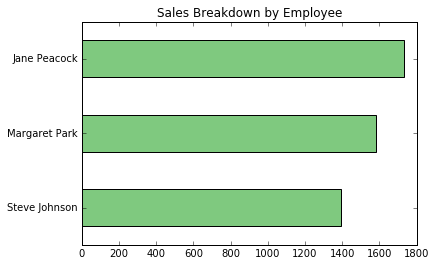

In [9]:

emp_sales = run_query(employee_performance)

emp_sales.set_index("employee", drop=True, inplace=True)
emp_sales.sort_values("total_sales", inplace=True)
emp_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

In [10]:
# Where a country has only one customer collect them into an "Other" group
sales_by_country = '''
with country_group AS (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
select 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value 
from
    (
    select country, 
    count(distinct customer_id) customers,  
    sum(unit_price) total_sales,
    sum(unit_price)/count(distinct customer_id) customer_lifetime_value,
    sum(unit_price)/count(distinct invoice_id) average_order,
    CASE 
        WHEN country = "Other" THEN 1
        ELSE 0
        END AS sort
    from country_group 
    group by country
    order by sort asc, total_sales desc
    );
    '''
        
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Dashboard Visualization
------

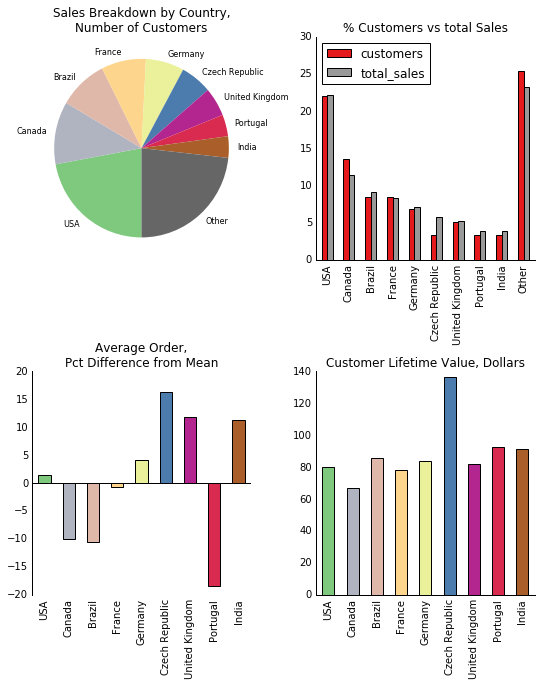

In [14]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="% Customers vs total Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\n % Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India